# CMS GIWAXS raw data processing & exporting notebook
In this notebook you output xr.DataSets stored as .zarr stores containing all your raw,
remeshed (reciprocal space), and caked CMS GIWAXS data. Saving as a zarr automatically converts the array to a dask array!

In [ ]:
### Kernel updates if needed, remember to restart kernel after running this cell!:
!pip install -e /nsls2/users/alevin/repos/PyHyperScattering  # to use pip to install via directory

## Imports

In [79]:
### Imports:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
import PyHyperScattering as phs
import pygix
from tqdm.auto import tqdm  # progress bar loader!

# Load custom pygix functions
pg_convert = phs.util.GIWAXS.pg_convert  
pg_convert_series = phs.util.GIWAXS.pg_convert_series

print(f'Using PyHyperScattering Version: {phs.__version__}')

Using PyHyperScattering Version: 0+untagged.502.g62cbee0


## Defining some objects

### Define & check paths

In [34]:
# I like pathlib for its readability & checkability, it's also necessary for the loadSeries function later on
# Replace the paths with the ones relevant to your data, you can use the ".exists()" method to make sure you defined a path correctly
userPath = pathlib.Path('/nsls2/users/alevin')  # Your users path is great for small items that are personal to you (100 GB limit)
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-2/pass-311415')  # The proposals path is a good place to store large data (>1 TB space?)
dataPath = propPath.joinpath('KWhite5')
maskponiPath = userPath.joinpath('giwaxs_suite/beamline_data/maskponi')
savePath = propPath.joinpath('AL_processed_data')

poniFile=maskponiPath.joinpath('LaB6_fixed_rot.poni')
maskFile=maskponiPath.joinpath('LaB6.json')

In [35]:
# List the files inside the dataPath folder
sorted([f.name for f in dataPath.iterdir()])  # a simple way to list just the filenames and not the whole path

['data',
 'maxs',
 'pm6_misc_cb_002',
 'pm6_misc_cb_18_100_22_80_75_006',
 'pm6_misc_cb_18_200_22_80_75_002',
 'pm6_misc_cb_18_200_22_80_75_003',
 'pm6_misc_cb_18_200_22_80_75_004',
 'pm6_misc_cb_18_200_30_80_75_007',
 'pm6_misc_cb_18_300_22_80_75_005',
 'pm6_misc_cb_18mgpml_200um_22mmps_sol80C_stg75C_001',
 'pm7_S1_95tol5cpme_14_100_18_85_75_009',
 'pm7_S1_95tol5cpme_14_100_22p7_85_75_008',
 'pm7_S1_95tol5cpme_14_100_26_85_75_010',
 'pm7_S1_95tol5cpme_14_200_22p7_85_75_008',
 'pybtz_CBCNp1_15_200_40_60_60_013',
 'pybtz_CBCNp5_15_200_40_60_60_014',
 'pybtz_CB_15_200_40_60_60_011',
 'pybtz_CB_15_200_40_60_60_012',
 'sam1_p3ht_toluene',
 'sam2_p3ht_toluene',
 'sam3_p3ht_toluene',
 'saxs',
 'test',
 'user_bladecoater.py',
 'waxs']

In [99]:
# Choose a sample folder and specify the sample data path
sample = 'pybtz_CBCNp5_15_200_40_60_60_014'
samplePath = dataPath.joinpath(sample, 'maxs/raw')  # CMS data is usually stored like this with the detector/raw
display(sorted([f.name for f in samplePath.iterdir()]))  # View all files

['pybtz_CBCNp5_15_200_40_60_60_014_1005.1s_x3.002_th0.100_5.00s_1118375_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1011.0s_x3.002_th0.100_5.00s_1118376_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1017.3s_x3.002_th0.140_5.00s_1118377_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1023.7s_x3.002_th0.200_5.00s_1118378_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1030.6s_x3.002_th0.500_5.00s_1118379_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1037.5s_x3.002_th0.120_5.00s_1118380_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1044.6s_x4.001_th0.100_5.00s_1118381_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1050.4s_x4.001_th0.100_5.00s_1118382_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1056.8s_x4.001_th0.140_5.00s_1118383_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1063.2s_x4.001_th0.200_5.00s_1118384_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1069.9s_x4.001_th0.500_5.00s_1118385_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1076.9s_x4.001_th0.120_5.00s_1118386_maxs

In [100]:
# Choose series scan id(s)
series_ids = ['1118329', '1118330', '1118331']

# Create separate sets for single vs series measurements, customize per your data:
# I had 3 different scan ids in one series measurement, so I combine them all first 
# before substracting them from the total file list
exp0p1_set = set(samplePath.glob(f'*{series_ids[0]}*')) 
exp0p5_set = set(samplePath.glob(f'*{series_ids[1]}*'))
exp2p0_set = set(samplePath.glob(f'*{series_ids[2]}*'))
qperp_set = set(samplePath.glob('*qperp*'))

series_set = exp0p1_set.union(exp0p5_set, exp2p0_set)
singles_set = set(samplePath.iterdir()).difference(series_set)
qpara_set = singles_set.difference(qperp_set)

# Check content of sets
print('qperp images:')
display(sorted([f.name for f in qperp_set]))

print('\nqpara images:')
display(sorted([f.name for f in qpara_set]))

print('\nimage series:')
display(sorted([f.name for f in series_set]))

qperp images:


['pybtz_CBCNp5_15_200_40_60_60_014_qperp_1586.6s_x-2.001_th0.100_5.00s_1118405_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_qperp_1592.4s_x-2.001_th0.100_5.00s_1118406_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_qperp_1598.9s_x-2.001_th0.140_5.00s_1118407_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_qperp_1605.2s_x-2.001_th0.200_5.00s_1118408_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_qperp_1612.0s_x-2.001_th0.500_5.00s_1118409_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_qperp_1618.9s_x-2.001_th0.120_5.00s_1118410_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_qperp_1626.0s_x-0.999_th0.100_5.00s_1118411_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_qperp_1631.8s_x-0.999_th0.100_5.00s_1118412_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_qperp_1638.2s_x-0.999_th0.140_5.00s_1118413_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_qperp_1644.6s_x-0.999_th0.200_5.00s_1118414_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_qperp_1651.5s_x-0.999_th0.500_5.00s_1118415_maxs.tiff',


qpara images:


['pybtz_CBCNp5_15_200_40_60_60_014_1005.1s_x3.002_th0.100_5.00s_1118375_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1011.0s_x3.002_th0.100_5.00s_1118376_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1017.3s_x3.002_th0.140_5.00s_1118377_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1023.7s_x3.002_th0.200_5.00s_1118378_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1030.6s_x3.002_th0.500_5.00s_1118379_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1037.5s_x3.002_th0.120_5.00s_1118380_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1044.6s_x4.001_th0.100_5.00s_1118381_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1050.4s_x4.001_th0.100_5.00s_1118382_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1056.8s_x4.001_th0.140_5.00s_1118383_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1063.2s_x4.001_th0.200_5.00s_1118384_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1069.9s_x4.001_th0.500_5.00s_1118385_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_1076.9s_x4.001_th0.120_5.00s_1118386_maxs


image series:


['pybtz_CBCNp5_15_200_40_60_60_014_544.2s_x0.000_th0.120_0.10s_1118329_000000_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_544.2s_x0.000_th0.120_0.10s_1118329_000001_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_544.2s_x0.000_th0.120_0.10s_1118329_000002_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_544.2s_x0.000_th0.120_0.10s_1118329_000003_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_544.2s_x0.000_th0.120_0.10s_1118329_000004_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_544.2s_x0.000_th0.120_0.10s_1118329_000005_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_544.2s_x0.000_th0.120_0.10s_1118329_000006_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_544.2s_x0.000_th0.120_0.10s_1118329_000007_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_544.2s_x0.000_th0.120_0.10s_1118329_000008_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_544.2s_x0.000_th0.120_0.10s_1118329_000009_maxs.tiff',
 'pybtz_CBCNp5_15_200_40_60_60_014_544.2s_x0.000_th0.120_0.10s_1118329_000010_maxs.tiff',
 'pybtz_CB

### Define metadata naming scheme & initialize loaders

In [101]:
# My example metadata filename naming schemes:
# Make sure the length of this list lines up with your filenames split by underscore (or however you split them)!

# For nonrotated, qpara images:
qpara_md_naming_scheme = ['material', 'solvent', 'concentration', 'gap_height', 'blade_speed',
                    'solution_temperature', 'stage_temperature', 'sample_number', 'time_start',
                    'x_position_offset', 'incident_angle', 'exposure_time', 'scan_id', 'detector']

# For rotated, qperp images:
qperp_md_naming_scheme = ['material', 'solvent', 'concentration', 'gap_height', 'blade_speed',
                    'solution_temperature', 'stage_temperature', 'sample_number', 'in-plane_orientation',
                    'time_start', 'x_position_offset', 'incident_angle', 'exposure_time', 'scan_id', 'detector']

# For in situ series images:
in_situ_md_naming_scheme = ['material', 'solvent', 'concentration', 'gap_height', 'blade_speed',
                    'solution_temperature', 'stage_temperature', 'sample_number', 'time_start',
                    'x_position_offset', 'incident_angle', 'exposure_time', 'scan_id', 
                    'series_number', 'detector']

# Initalize CMSGIWAXSLoader objects with the above naming schemes
qpara_loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=qpara_md_naming_scheme)
qperp_loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=qperp_md_naming_scheme)
series_loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=in_situ_md_naming_scheme)

## Data processing
Break this section however makes sense for your data

### qperp set

#### Load the images into a single xr.DataSet:

In [102]:
# Select the first element of the sorted set outside of the for loop to initialize the xr.DataSet
DA = qperp_loader.loadSingleImage(sorted(qperp_set)[0])
recip_DA, caked_DA = pg_convert(DA, poniFile, maskFile, inplane_config='q_perp')

# Create a DataSet, each DataArray will be named according to it's scan id
raw_DS = DA.to_dataset(name=DA.scan_id)
recip_DS = recip_DA.to_dataset(name=DA.scan_id)
caked_DS = caked_DA.to_dataset(name=DA.scan_id)

# Populate the DataSet with 
for filepath in tqdm(sorted(qperp_set)[1:]):
    DA = qperp_loader.loadSingleImage(filepath)
    recip_DA, caked_DA = pg_convert(DA, poniFile, maskFile, inplane_config='q_perp')
    
    raw_DS[f'{DA.scan_id}'] = DA
    recip_DS[f'{DA.scan_id}'] = recip_DA    
    recip_DS[f'{DA.scan_id}'] = recip_DA

  0%|          | 0/29 [00:00<?, ?it/s]

#### Save dataset as a .zarr store:

In [103]:
# Specify a suffix for saving the raw, recip, and caked DataSets. 
# I use a try/except statement because not all my DataArrays will have the same attribute present
try: 
    orientation = DA.attrs['in-plane_orientation']
except KeyError:
    orientation = 'qpara' 
finally:
    suffix=f'{DA.material}_{orientation}_{DA.sample_number}'

raw_DS.to_zarr(savePath.joinpath('qperp_zarrs', f'raw_{suffix}.zarr'), mode='w')
recip_DS.to_zarr(savePath.joinpath('qperp_zarrs', f'recip_{suffix}.zarr'), mode='w')
caked_DS.to_zarr(savePath.joinpath('qperp_zarrs', f'caked_{suffix}.zarr'), mode='w')

### qpara set

#### Load the images into a single xr.DataSet:

In [104]:
# Select the first element of the sorted set outside of the for loop to initialize the xr.DataSet
DA = qpara_loader.loadSingleImage(sorted(qpara_set)[0])
recip_DA, caked_DA = pg_convert(DA, poniFile, maskFile, inplane_config='q_para')

# Create a DataSet, each DataArray will be named according to it's scan id
raw_DS = DA.to_dataset(name=DA.scan_id)
recip_DS = recip_DA.to_dataset(name=DA.scan_id)
caked_DS = caked_DA.to_dataset(name=DA.scan_id)

# Populate the DataSet with 
for filepath in tqdm(sorted(qpara_set)[1:]):
    DA = qpara_loader.loadSingleImage(filepath)
    recip_DA, caked_DA = pg_convert(DA, poniFile, maskFile, inplane_config='q_para')
    
    raw_DS[f'{DA.scan_id}'] = DA
    recip_DS[f'{DA.scan_id}'] = recip_DA    
    caked_DS[f'{DA.scan_id}'] = caked_DA

  0%|          | 0/79 [00:00<?, ?it/s]

#### Save dataset as a .zarr store:

In [105]:
# Specify a suffix for saving the raw, recip, and caked DataSets. 
# I use a try/except statement because not all my DataArrays will have the same attribute present
try: 
    orientation = DA.attrs['in-plane_orientation']
except KeyError:
    orientation = 'qpara' 
finally:
    suffix=f'{DA.material}_{orientation}_{DA.sample_number}'

raw_DS.to_zarr(savePath.joinpath('qpara_zarrs', f'raw_{suffix}.zarr'), mode='w')
recip_DS.to_zarr(savePath.joinpath('qpara_zarrs', f'recip_{suffix}.zarr'), mode='w')
caked_DS.to_zarr(savePath.joinpath('qpara_zarrs', f'caked_{suffix}.zarr'), mode='w')

### series set

#### Save each series as its own DataSet
The time dimension doesn't line up for this, so it isn't very amenable for all the series to be stored
together. Better to just store them as their own arrays. Zarr requires DataSets to work with, so we convert to a DataSet just to save them.

In [106]:
time_starts = [0, 10, 90]
time_ranges = ['0to10', '10to90', '90to180']
for i, series in enumerate((exp0p1_set, exp0p5_set, exp2p0_set)):
    # Select the first element of the sorted set outside of the for loop to initialize the xr.DataSet
    DA = series_loader.loadSeries(sorted(series), time_start= time_starts[i])
    recip_DA, caked_DA = pg_convert_series(DA, poniFile, maskFile, inplane_config='q_para')

    # Transform DataArrays into DataSets & save as .zarr stores
    raw_DS = DA.to_dataset(name='DA')
    recip_DS = recip_DA.to_dataset(name='DA')
    caked_DS = caked_DA.to_dataset(name='DA')

    # Specify a suffix for saving the raw, recip, and caked DataSets. 
    suffix = f'{DA.scan_id}_{DA.material}_{time_ranges[i]}s_qpara_{DA.sample_number}_'

    raw_DS.to_zarr(savePath.joinpath('series_zarrs', f'raw_{suffix}.zarr'), mode='w')
    recip_DS.to_zarr(savePath.joinpath('series_zarrs', f'recip_{suffix}.zarr'), mode='w')
    caked_DS.to_zarr(savePath.joinpath('series_zarrs', f'caked_{suffix}.zarr'), mode='w')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

## Unorganized plotting cells used to check data

In [113]:
# Example of how to load a zarr dataset:
DS = xr.open_zarr(savePath.joinpath('series_zarrs', f'caked_{suffix}.zarr'))
DS.DA

<xarray.DataArray 'DA' (time: 45, chi: 180, qr: 1000)>
dask.array<open_dataset-DA, shape=(45, 180, 1000), dtype=float32, chunksize=(12, 45, 500), chunktype=numpy.ndarray>
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * qr       (qr) float64 0.179 0.1825 0.1861 0.1896 ... 3.717 3.721 3.724 3.728
  * time     (time) float64 92.0 94.0 96.0 98.0 ... 174.0 176.0 178.0 180.0
Attributes: (12/15)
    blade_speed:           40
    concentration:         15
    detector:              maxs.tiff
    exposure_time:         2.00s
    gap_height:            200
    incident_angle:        th0.120
    ...                    ...
    scan_id:               1118331
    solution_temperature:  60
    solvent:               CBCNp5
    stage_temperature:     60
    time_start:            721.4s
    x_position_offset:     x0.000

In [26]:
# ax = recip_DA.sel(q_perp=slice(-2, 1), q_z=slice(-0.01, 2)).plot.imshow(norm=LogNorm(4e1, 2.5e3), cmap=plt.cm.turbo, interpolation='antialiased')
# ax.axes.set(aspect='equal', xlabel='$q_{perp}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$', title=f'1% CN, 5 s exposure, 0.12° incident angle')
# ax.figure.set(size_inches=(7,3.5), tight_layout=True)
# plt.show()
# # ax.figure.savefig(savePath.joinpath(f'{recip_da.material}_{recip_da.solvent}_qperp_{recip_da.incident_angle}_{recip_da.exposure_time}_{recip_da.scan_id}.png'), dpi=120)
# plt.close('all')

In [ ]:
### Define color limits acceptable for the different exposure times
recip_vlims = {
    recip_pybtz_CB_0to10s_series.exposure_time: (0.8, 4e1),
    recip_pybtz_CB_10to90s_series.exposure_time: (4, 2e2),
    recip_pybtz_CB_90to180s_series.exposure_time: (3e1, 1e3)
}

### Select 2D Plot

In [28]:
cmap = plt.cm.turbo
cmap.set_bad('black')

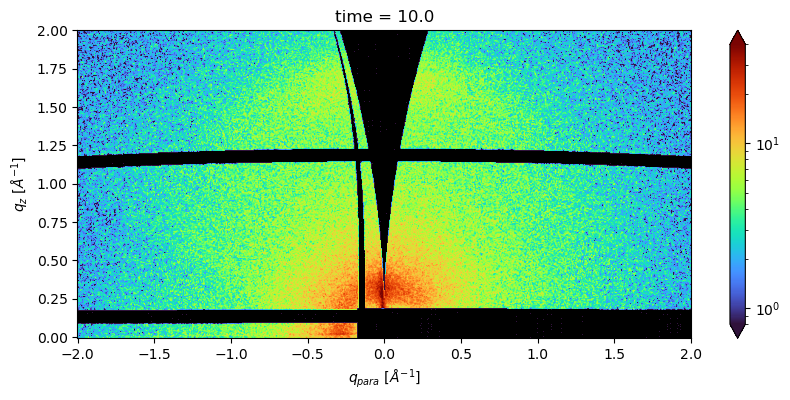

In [40]:
ax = recip_DA.sel(time=120, method='nearest').sel(q_z=slice(-0.01,2), q_para=slice(-2,2)).plot.imshow(cmap=cmap, norm=LogNorm(0.8, 4e1), figsize=(10,4), interpolation='antialiased')
ax.axes.set(aspect='equal', xlabel='$q_{para}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$')
plt.show()

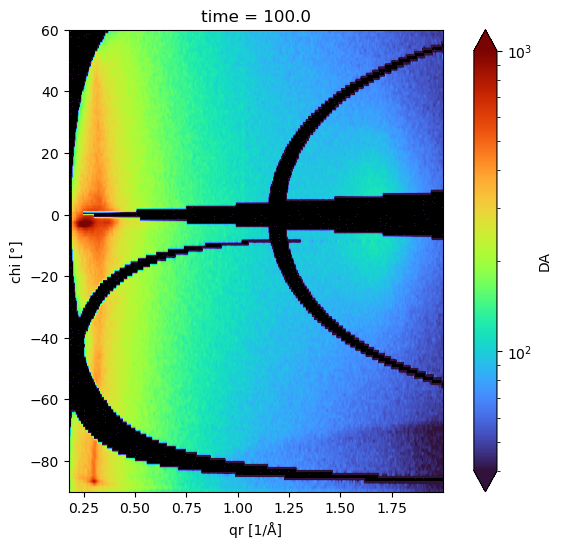

In [112]:
ax = DS.DA.sel(time=100, qr=slice(0,2), chi=slice(-90, 60)).plot.imshow(cmap=cmap, norm=LogNorm(4e1, 1e3), figsize=(8,6), interpolation='antialiased')
ax.axes.set(aspect=1.5e-2)
plt.show()

In [ ]:
caked_pybtz_CB_0to10s_series.sel(time=slice(0,1)).plot(col='time', col_size=4)

In [ ]:
caked_pybtz_CB_90to180s_series.sel(time=100, qr=slice(0,2), chi=slice(5,25)).sum('chi').plot()

In [ ]:
selected_dataarrays = [da for da in caked_DS.data_vars.values() 
                       if da.attrs['exposure_time'] == '5.00s' and 
                       da.attrs['incident_angle'] == 'th0.120']
len(selected_dataarrays)